In [59]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from lib.obs import asos_raw, hourly_precip
from events_calc import precip_events

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
stations = ['SAC', 'RNO']
time_period = list(map(pd.Timestamp, ('1980-07-01', '2020-06-30')))

In [37]:
precips = hourly_precip(stations, *time_period)

In [38]:
rain_clusts = precip_events(precips, eps=6, min_samples=12, chunks=20)
outliers = rain_clusts < 0
rain_events = precips.copy()
rain_events['clust'] = rain_clusts
rain_events = rain_events[~outliers]

In [39]:
events_agg = rain_events.groupby(['station', 'clust'], as_index=False).agg({
    'precip_in': sum,
    'valid': [min, max],
})

events_agg.columns.droplevel(level=0)
events_agg.columns = ['station', 'clust', 'precip_in', 'min_time', 'max_time'] 

In [40]:
sfos = events_agg[events_agg.station == 'SAC']
renos = events_agg[events_agg.station == 'RNO']
combined = sfos.merge(renos, on='clust', how='inner', suffixes=['_sac', '_reno'])

In [41]:
in_djfm_sac = combined.min_time_sac.dt.month.isin([12, 1, 2, 3])
in_djfm_reno = combined.min_time_reno.dt.month.isin([12, 1, 2, 3])

combined = combined[in_djfm_sac & in_djfm_reno]
combined

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno
1,SAC,4,1.30,1980-12-03 02:00:00,1980-12-04 09:00:00,RNO,0.60,1980-12-04 01:00:00,1980-12-04 14:00:00
2,SAC,8,2.76,1981-01-26 13:00:00,1981-01-29 09:00:00,RNO,0.74,1981-01-27 06:00:00,1981-01-29 13:00:00
3,SAC,9,0.08,1981-02-09 01:00:00,1981-02-09 08:00:00,RNO,0.15,1981-02-09 00:00:00,1981-02-09 14:00:00
4,SAC,10,0.24,1981-02-13 13:00:00,1981-02-13 19:00:00,RNO,0.01,1981-02-13 21:00:00,1981-02-13 21:00:00
5,SAC,11,0.11,1981-02-25 11:00:00,1981-02-25 14:00:00,RNO,0.03,1981-02-25 11:00:00,1981-02-25 12:00:00
...,...,...,...,...,...,...,...,...,...
700,SAC,1279,0.25,2019-12-29 23:00:00,2019-12-30 03:00:00,RNO,0.02,2019-12-30 03:00:00,2019-12-30 04:00:00
701,SAC,1281,0.32,2020-01-16 16:00:00,2020-01-16 22:00:00,RNO,0.10,2020-01-16 21:00:00,2020-01-16 22:00:00
702,SAC,1282,0.26,2020-01-26 05:00:00,2020-01-26 14:00:00,RNO,0.01,2020-01-26 09:00:00,2020-01-26 09:00:00
703,SAC,1286,0.24,2020-03-15 07:00:00,2020-03-15 17:00:00,RNO,0.03,2020-03-15 09:00:00,2020-03-15 13:00:00


(0.0, 3.0)

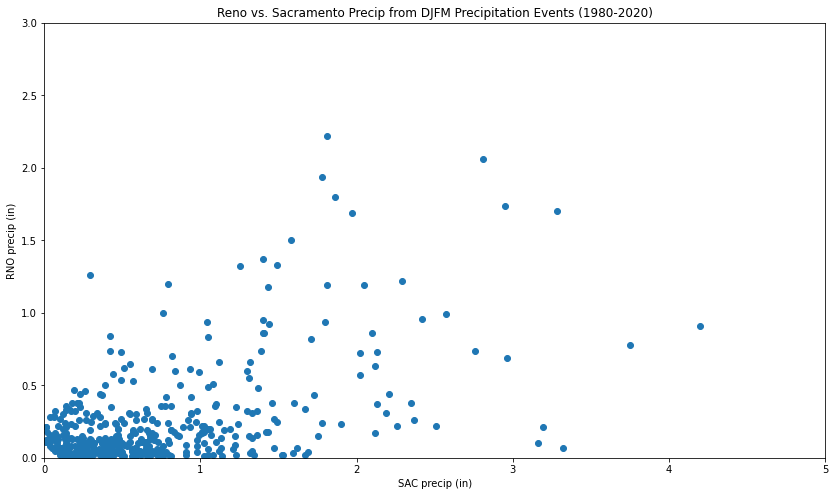

In [42]:
plt.figure(figsize=(14, 8))
plt.scatter(x=combined.precip_in_sac, y=combined.precip_in_reno)
plt.title(f'Reno vs. Sacramento Precip from DJFM Precipitation Events ({time_period[0]:%Y}-{time_period[1]:%Y})')
plt.xlabel('SAC precip (in)')
plt.xlim([0, 5])
plt.ylabel('RNO precip (in)')
plt.ylim([0, 3])

In [43]:
threshold = combined.precip_in_sac.mean() + 1.5 * combined.precip_in_sac.std()
threshold

1.787233104343078

In [44]:
big_events = combined[(combined.precip_in_sac > threshold) & (combined.precip_in_sac < 5)]
big_events['rno_sac_ratio'] = big_events.precip_in_reno / big_events.precip_in_sac
big_events.shape

<ipython-input-44-b1dbf9e03b01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events['rno_sac_ratio'] = big_events.precip_in_reno / big_events.precip_in_sac


(33, 10)

In [50]:
strong_shadow = big_events.sort_values(by='rno_sac_ratio').head(10) 
weak_shadow = big_events.sort_values(by='rno_sac_ratio').tail(10)

In [51]:
strong_shadow

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno,rno_sac_ratio
658,SAC,1214,3.32,2018-01-08 11:00:00,2018-01-09 14:00:00,RNO,0.07,2018-01-09 02:00:00,2018-01-09 13:00:00,0.021084
688,SAC,1254,3.16,2019-02-25 20:00:00,2019-02-28 02:00:00,RNO,0.10,2019-02-27 11:00:00,2019-02-27 12:00:00,0.031646
239,SAC,411,3.19,1993-01-12 21:00:00,1993-01-14 12:00:00,RNO,0.21,1993-01-13 00:00:00,1993-01-14 14:00:00,0.065831
472,SAC,888,2.12,2008-01-21 18:00:00,2008-01-24 11:00:00,RNO,0.17,2008-01-21 18:00:00,2008-01-24 11:00:00,0.080189
95,SAC,133,2.51,1983-12-24 11:00:00,1983-12-25 22:00:00,RNO,0.22,1983-12-24 07:00:00,1983-12-26 00:00:00,0.087649
69,SAC,96,2.26,1983-03-12 09:00:00,1983-03-13 21:00:00,RNO,0.22,1983-03-13 10:00:00,1983-03-13 17:00:00,0.097345
577,SAC,1074,2.37,2014-02-07 18:00:00,2014-02-10 10:00:00,RNO,0.26,2014-02-08 18:00:00,2014-02-10 11:00:00,0.109705
539,SAC,1000,1.90,2011-03-14 00:00:00,2011-03-14 23:00:00,RNO,0.23,2011-03-14 08:00:00,2011-03-14 10:00:00,0.121053
640,SAC,1185,2.19,2017-02-06 01:00:00,2017-02-07 17:00:00,RNO,0.31,2017-02-07 11:00:00,2017-02-07 16:00:00,0.141553
36,SAC,51,2.35,1982-03-30 21:00:00,1982-03-31 22:00:00,RNO,0.38,1982-03-31 10:00:00,1982-03-31 19:00:00,0.161702


In [60]:
strong_shadow_means = strong_shadow[['min_time_sac', 'min_time_reno']].apply(np.mean, axis=1)
strong_shadow_means

658   2018-01-08 18:30:00
688   2019-02-26 15:30:00
239   1993-01-12 22:30:00
472   2008-01-21 18:00:00
95    1983-12-24 09:00:00
69    1983-03-12 21:30:00
577   2014-02-08 06:00:00
539   2011-03-14 04:00:00
640   2017-02-06 18:00:00
36    1982-03-31 03:30:00
dtype: datetime64[ns]

In [62]:
# from lib.ncep_r1 import ftp_cdc_esrl_file, export_file_for_ftp
# export_file_for_ftp(strong_shadow_means, 'strong_sierra_shadow2.csv')
# ftp_cdc_esrl_file('strong_sierra_shadow2.csv', 'a@b.co')

FTP to /Public/incoming/dates//strong_sierra_shadow2.csv


In [53]:
weak_shadow

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno,rno_sac_ratio
631,SAC,1176,3.28,2017-01-07 09:00:00,2017-01-09 09:00:00,RNO,1.70,2017-01-07 16:00:00,2017-01-09 12:00:00,0.518293
464,SAC,878,1.80,2007-12-06 16:00:00,2007-12-07 13:00:00,RNO,0.94,2007-12-06 21:00:00,2007-12-07 17:00:00,0.522222
632,SAC,1177,2.29,2017-01-10 01:00:00,2017-01-11 15:00:00,RNO,1.22,2017-01-10 03:00:00,2017-01-11 10:00:00,0.532751
385,SAC,754,2.05,2004-02-25 11:00:00,2004-02-26 19:00:00,RNO,1.19,2004-02-25 16:00:00,2004-02-26 13:00:00,0.580488
425,SAC,811,2.95,2005-12-30 22:00:00,2005-12-31 17:00:00,RNO,1.74,2005-12-30 18:00:00,2005-12-31 22:00:00,0.589831
337,SAC,669,1.81,2001-12-01 06:00:00,2001-12-03 11:00:00,RNO,1.19,2001-12-02 10:00:00,2001-12-03 05:00:00,0.657459
686,SAC,1252,2.81,2019-02-13 07:00:00,2019-02-15 21:00:00,RNO,2.06,2019-02-13 14:00:00,2019-02-15 22:00:00,0.733096
355,SAC,703,1.97,2002-12-14 21:00:00,2002-12-16 16:00:00,RNO,1.69,2002-12-15 00:00:00,2002-12-17 02:00:00,0.857868
198,SAC,324,1.86,1990-02-16 04:00:00,1990-02-17 00:00:00,RNO,1.80,1990-02-16 09:00:00,1990-02-16 23:00:00,0.967742
644,SAC,1191,1.81,2017-02-20 09:00:00,2017-02-21 22:00:00,RNO,2.22,2017-02-20 11:00:00,2017-02-22 11:00:00,1.226519


In [63]:
weak_shadow_means = weak_shadow[['min_time_sac', 'min_time_reno']].apply(np.mean, axis=1)
weak_shadow_means

631   2017-01-07 12:30:00
464   2007-12-06 18:30:00
632   2017-01-10 02:00:00
385   2004-02-25 13:30:00
425   2005-12-30 20:00:00
337   2001-12-01 20:00:00
686   2019-02-13 10:30:00
355   2002-12-14 22:30:00
198   1990-02-16 06:30:00
644   2017-02-20 10:00:00
dtype: datetime64[ns]

In [66]:
# export_file_for_ftp(weak_shadow_means, 'weak_sierra_shadow2b.csv')
# ftp_cdc_esrl_file('weak_sierra_shadow2b.csv', 'a@b.co')

FTP to /Public/incoming/dates//weak_sierra_shadow2b.csv
